# Classification

In [1]:
import sys
sys.path.append("C:\\Users\\User\\Vrije Universiteit Brussel\\Mehdi Feizpour - Halewijn's Thesis Project\\master thesis\\other")
sys.path.append("C:\\Users\\mfeizpou\\OneDrive - Vrije Universiteit Brussel\\Halewijn's Thesis Project\\master thesis\other")


import importlib
import my_functions as mf
import filepaths as fp
import color_maps as cm
import variables
import classes
mf = importlib.reload(mf)
fp = importlib.reload(fp)
cm = importlib.reload(cm)
variables = importlib.reload(variables)
classes = importlib.reload(classes)

import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter



from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
import pickle
from sklearn.metrics import accuracy_score


In [2]:
def reload_libraries(): 
    import importlib
    import my_functions as mf
    import filepaths as fp
    import color_maps as cm
    import variables
    import classes
    mf = importlib.reload(mf)
    fp = importlib.reload(fp)
    cm = importlib.reload(cm)
    variables = importlib.reload(variables)
    classes = importlib.reload(classes)
    print('done')

In [76]:
reload_libraries()
structured_measurement_dict = {
    'E coli': ['898f956e', '8ed404cc', '9223f703'],
    'P vulneris': ['fcf8eccf', '3b81b0bb', '3abf25a5'], 
    'S epidermis': ['a5832e62', '328e5e60'],
}


preprocessing_params = {'window_length': 20, 
                            'polyorder':3, 
                       'normalization': True, 
                       'cosmic_ray_removal':True,
                       'cosmic_ray_z_score': 5}

raman_database = classes.Raman_database(structured_measurement_dict, preprocessing_params=preprocessing_params)
df = raman_database.concatenate_raman_dataframes()
vector_df = mf.get_vector_df(df[['measurement_index', 'wavenumber', 'intensity', 'Class']], 'intensity')
vector_df.to_csv(fp.second_semester_data_path + '/' + 'vector_df.csv', index=False)
melt_df = mf.get_melt_df(vector_df)

done


In [77]:
mf.describe_class_distribution(vector_df)

,Class,num_samples,percentage
0,E coli,290,42.9
1,P vulneris,290,42.9
2,S epidermis,96,14.2


in total, there are 676 samples


<Axes: xlabel='wavenumber', ylabel='intensity'>

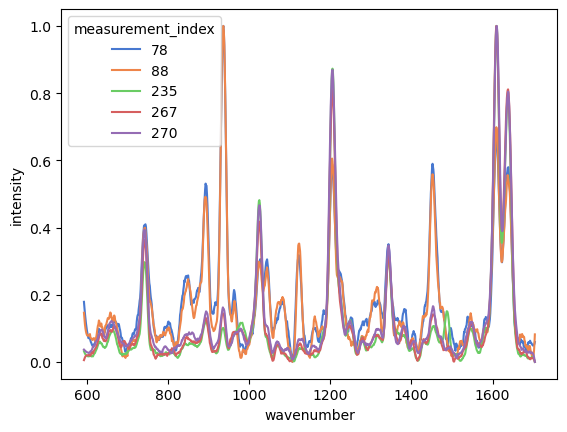

In [84]:
data = mf.get_random_sample_from_class(melt_df, 'E coli', 5)
sns.lineplot(data = data, x= 'wavenumber', y= 'intensity', hue = 'measurement_index', palette = 'muted')

## PCA

In [85]:
#initialize the data that will be used
data = vector_df.iloc[:, 2:]
# Initialize SimpleImputer to replace NaN values with column means
imputer = SimpleImputer(strategy='mean')
# Fit and transform the data to replace NaN values with column means
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
# Do a standard scaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data.columns)
# Do a PCA
pca = PCA()
# Fit and transform the data using PCA
data_pca = pd.DataFrame(pca.fit_transform(data_scaled))
#stitch the labels to it
data_pca_labels = mf.stitch_labels(data_pca, vector_df.loc[:, 'Class'])

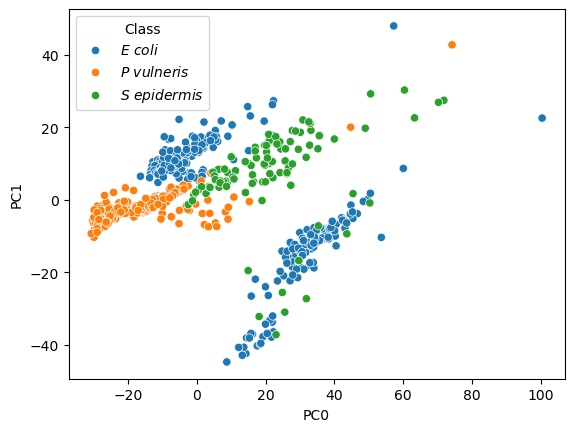

In [86]:
filename = 'pca.png'
sns.scatterplot(data = mf.replace_bacterial_names_for_plotting(data_pca_labels), x = 0, y = 1, hue = 'Class')
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.savefig(fp.figure_filepath +'/' + 'results_figures'+ '/' + filename)
plt.show()

## LDA

done


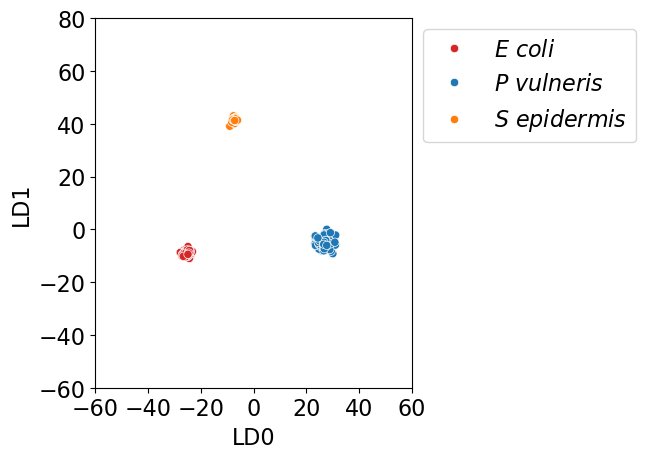

done


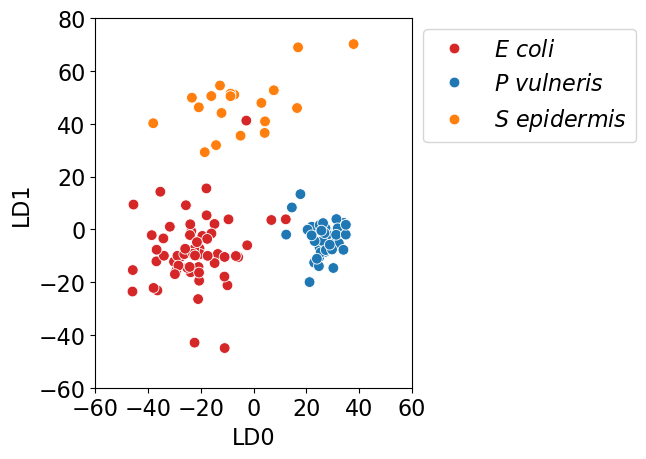

In [87]:
#initialize the data that will be used
data = vector_df.iloc[:, 2:]
#initialize the labels
labels = vector_df.loc[:, 'Class']
# Split your data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# Initialize the Gaussian mixture model
gmm = GaussianMixture(n_components=4) 

#make the pipeline
lda_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

#GMM pipeline
gmm_pipeline = Pipeline([
    ('gmm', GaussianMixture(n_components=3))  # Adjust n_components for GMM
])

# Combined Pipeline
combined_pipeline = Pipeline([
    ('lda', lda_pipeline),
    ('gmm', gmm_pipeline)
])


# #make the train_lda_df
# train_lda_df = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
# #predict the train labels
# train_labels = gmm_pipeline.fit_predict(train_lda_df)
# #make the test_lda_df
# test_lda_df = pd.DataFrame(lda_pipeline.transform(X_test))
# #make the test predictions
# test_labels = gmm_pipeline.predict(test_lda_df)

# # Predict the labels using GMM
# predicted_labels_gmm = gmm.predict(data)

X, y = mf.get_X_y_from_vector_df(vector_df)

# Splitting the data into training and testing sets with a 70-30 split ratio
random_state = 53
random_state = 43
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = random_state)

#fit_transform the lda_df
train_lda = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
#fit_transform the lda_df
test_lda = pd.DataFrame(lda_pipeline.transform(X_test))

reload_libraries()
filename = 'LDA_2d.png'

#the train data
#stitch the labels to it
train_lda_labels = mf.stitch_labels(train_lda, y_train)
test_lda_labels = mf.stitch_labels(test_lda, y_test)

x1, x2 = -60, 60
y1, y2 = -60, 80

df = mf.replace_bacterial_names_for_plotting(train_lda_labels)
sns.scatterplot(data =df, x = 0, y = 1, hue = 'Class', palette=variables.italics_bacterial_colormp)
plt.xlabel('LD0', fontsize = variables.x_y_label_fontsize)
plt.ylabel('LD1', fontsize = variables.x_y_label_fontsize)
plt.xticks(fontsize=variables.tick_fontsize)
plt.yticks(fontsize=variables.tick_fontsize)
plt.xlim((x1, x2))
plt.ylim((y1, y2))
ax = plt.gca()
ax.set_aspect('equal')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = variables.legend_fontsize)

plt.savefig(fp.figure_filepath + '/' + 'lda_train.png', bbox_inches = 'tight', dpi = 1200, transparent = True)

plt.show()

reload_libraries()
#df = mf.map_color(test_lda_labels, 'Class', variables.new_bacterial_colormap)
df = mf.replace_bacterial_names_for_plotting(test_lda_labels)
sns.scatterplot(data =df, x = 0, y = 1, hue = 'Class', palette=variables.italics_bacterial_colormp, s = 60)
plt.xlabel('LD0', fontsize = variables.x_y_label_fontsize)
plt.ylabel('LD1', fontsize = variables.x_y_label_fontsize)
plt.xticks(fontsize=variables.tick_fontsize)
plt.yticks(fontsize=variables.tick_fontsize)
plt.xlim((x1, x2))
plt.ylim((y1, y2))
ax = plt.gca()
ax.set_aspect('equal')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = variables.legend_fontsize)

plt.savefig(fp.figure_filepath + '/' + 'lda_test.png', bbox_inches = 'tight', dpi = 1200, transparent = True)
plt.show()

### perform a gaussian mixture model

In [88]:
reload_libraries()
#make the train_lda_df
train_lda_df = pd.DataFrame(lda_pipeline.fit_transform(X_train.values, y_train))
#predict the train labels
train_predictions = gmm_pipeline.fit_predict(train_lda_df.values)
#make the test_lda_df
test_lda_df = pd.DataFrame(lda_pipeline.transform(X_test.values))
#make the test predictions
test_predictions = gmm_pipeline.predict(test_lda_df.values)

#save the model
#save the lda pipeline
mf.save_pickle(fp.second_semester_model_path + '/' + 'lda_pipeline.pkl', lda_pipeline)
#save the gmm pipeline
mf.save_pickle(fp.second_semester_model_path + '/' + 'gmm_pipeline.pkl', gmm_pipeline)

# Create a DataFrame to associate original labels with cluster assignments
train_df = pd.DataFrame({'true_class': y_train, 'gmm_predicted_class': train_predictions})
#create the test df
test_df = pd.DataFrame({'true_class': y_test, 'gmm_predicted_class': test_predictions})


#get the map based on majority voting
map = train_df.groupby('true_class').apply(mf.majority_vote).reset_index().rename({
    'true_class': 'gmm_class',
    0: 'gmm_class_numerical'}, axis = 1)
#save the map in order to use it in another file
map.to_csv(fp.intermediate_data_filepath + '/' + 'gmm_map.csv', index = False)

#now apply this majority map
class_train_df = mf.convert_GMM_to_class_labels(train_df, map)
class_test_df = mf.convert_GMM_to_class_labels(test_df, map)

done


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


#### Performance of Gaussiamn mixture model

done


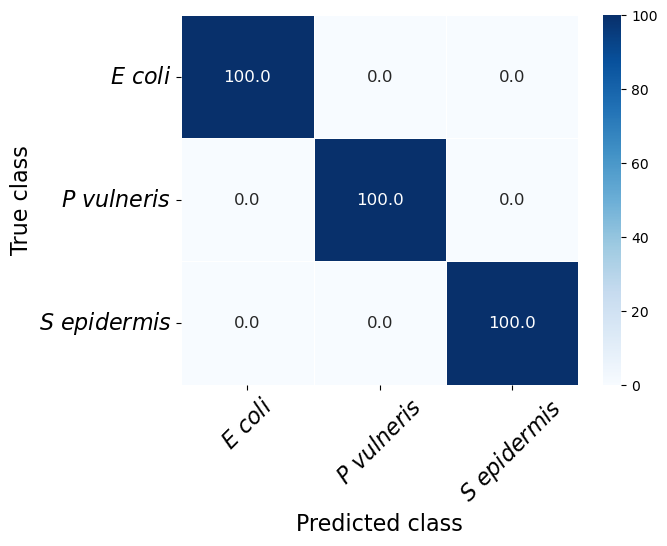

In [94]:
reload_libraries()
filename = 'lda_gmm_train_results.png'
df = mf.plot_confusion_matrix(class_train_df, map,filename, variables.x_y_label_fontsize)

done


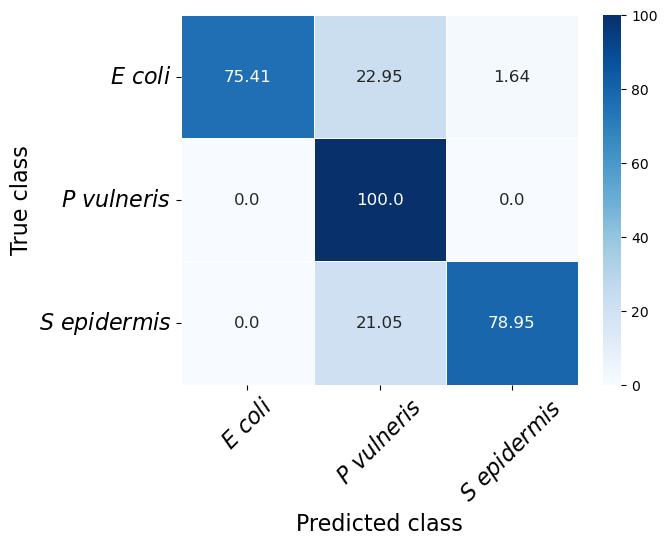

In [95]:
reload_libraries()
filename = 'lda_gmm_test_results.png'
mf.plot_confusion_matrix(class_test_df, map,filename, fontsize=variables.x_y_label_fontsize)

In [91]:
accuracy_score(class_test_df.true_gmm_class.values, class_test_df.gmm_predicted_class.values)

0.8602941176470589

#### the learning curve

In [ ]:
reload_libraries()
def get_train_and_test_accuracy_for_learning_curve(X_train, X_test, y_train, y_test, num_samples_in_subset, n_components): 
    #the ramining X_train and y_train we're going to subset and train on that
    #we select the number of samples that we want
    subset_X_train = X_train.sample(n = num_samples_in_subset)
    idx = subset_X_train.index.values
    subset_y_train = y_train[idx]
    class_train_df, class_test_df =mf.train_model_and_get_results_for_learning_curve(subset_X_train, X_test, subset_y_train, y_test, n_components)
    train_accuracy, f1 = mf.get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
    test_accuracy, f1 = mf.get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
    return train_accuracy, test_accuracy

In [ ]:
import warnings
warnings.filterwarnings('ignore')
averaging_measurements = 20
X, y = mf.get_X_y_from_vector_df(vector_df)
#let's use 20 percent of the samples as our test set

num_samples_array = np.arange(100, 300, 50)
train_accuracy_array = []
test_accuracy_array = []
num_samples_full_array = []
for ii in range(averaging_measurements): 
    print(ii)
    for num_samples_in_subset in num_samples_array: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        train_accuracy, test_accuracy = get_train_and_test_accuracy_for_learning_curve(X_train, X_test, y_train, y_test, num_samples_in_subset, 3)
        train_accuracy_array += [train_accuracy]
        test_accuracy_array += [test_accuracy]
        num_samples_full_array += [num_samples_in_subset]
    

In [ ]:
results_df = pd.DataFrame({'num_training_samples': num_samples_full_array, 
             'train accuracy': train_accuracy_array,
             'test accuracy': test_accuracy_array})
melted_df = pd.melt(results_df, id_vars=['num_training_samples'], 
                    value_vars=['train accuracy', 'test accuracy'], 
                    var_name='score type', value_name='accuracy')
sns.lineplot(data = melted_df, x= 'num_training_samples', y= 'accuracy', hue = 'score type')
sns.scatterplot(data = melted_df, x= 'num_training_samples', y= 'accuracy', hue = 'score type', legend = False,s = 10)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
#plt.xlim((999, 3000))
plt.show()

#### Visualizing the important components of the LDA

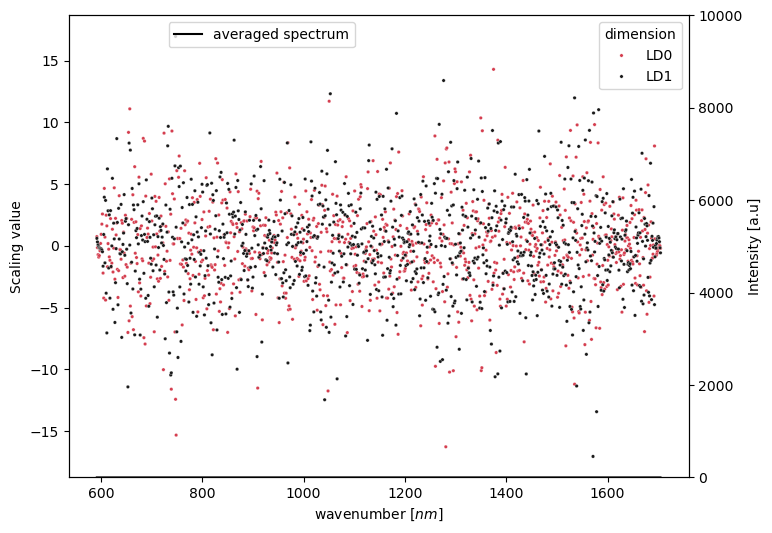

In [98]:
#make the loadings dataframe and plot it
loadings = lda_pipeline['lda'].scalings_
loadings_df = pd.DataFrame(loadings)
loadings_df.loc[:, 'wavenumber'] = np.array(list(vector_df.columns[2:])).astype('float')

loadings_df = loadings_df.melt(id_vars = 'wavenumber' , var_name = 'dimension',value_name='loading')
loadings_df.loc[:, 'dimension'] = loadings_df.loc[:, 'dimension'].astype('int')
# loadings_df = map_color(loadings_df, 'dimension', cm.three_d_color_axis)
loadings_df.loc[:, 'dimension'] = loadings_df.loc[:, 'dimension'].map({0: 'LD0', 1: 'LD1', 2: 'LD2'})
#plot it 
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = loadings_df, x= 'wavenumber', y = 'loading', hue = 'dimension',ax = ax1, s= 6, palette = cm.three_d_color_axis)
# Set the y-axis label for the first plot
ax1.set_ylabel('Scaling value')
ax1.set_xlabel('Wavenumber [$cm^{-1}$]')
ax1.set_xlabel('wavenumber [$nm$]')


#create the second plot
scale = 10
offset = 2

# Create a second y-axis for the second plot
ax2 = ax1.twinx()
# Shift the position of the second y-axis
#now overplot the averaged dataframe
melt_df = mf.get_melt_df(vector_df)
average_spectrum = melt_df.groupby(['wavenumber'], as_index = False)['intensity'].mean()
average_spectrum =  mf.replace_bacterial_names_for_plotting(average_spectrum)
sns.lineplot(data = average_spectrum, x = 'wavenumber', y = 'intensity',ax=ax2, c = 'black', label = 'averaged spectrum')
plt.legend(loc = 'upper left', bbox_to_anchor = (0.15, 1))
ax2.set_ylim(0,10000)
ax2.set_ylabel('Intensity [a.u]')

ax2.set_xlabel('wavenumber [$cm^{-1}$]')
filename = 'LDA_loadings.png'
plt.savefig(fp.figure_filepath + '/' + filename)
plt.show()

#### anomaly detection

In [ ]:
# Read the vector data
classes = vector_df['Class'].unique()
threshold_array = []
for class_ in classes: 
    threshold = mf.get_mahalanobis_distance_threshold(lda_pipeline, vector_df, class_, 5)
    threshold_array += [threshold]

threshold_df = pd.DataFrame({'Class': classes, 
             'threshold': threshold_array})
threshold_df.to_csv(fp.intermediate_data_filepath + '/' + 'threshold_distance.csv', index = False)

### Perform a Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
X, y = mf.get_X_y_from_vector_df(vector_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

with open(fp.model_filepath + '/' + 'lda_pipeline.pkl', 'rb') as lda_file:
    lda_pipeline = pickle.load(lda_file)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

In [ ]:
X_train_lda = lda_pipeline.transform(X_train)
X_test_lda = lda_pipeline.transform(X_test)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_lda, y_train)
y_pred = nb_classifier.predict(X_test_lda)
probabilities = nb_classifier.predict_proba(X_test_lda)
df = pd.DataFrame(probabilities)
(df[0] + df[1] + df[2] + df[3]).min()

In [ ]:
testing_data_path = fp.second_semester_directory + '/' + 'raman_prediction' + '/' + 'testing_datafolder'
df = pd.read_csv(testing_data_path + '/' + 'ecoli_df.csv')
X, y = mf.get_X_y_from_vector_df(mf.get_vector_df(df, 'intensity'))
lda_transformed_data = lda_pipeline.transform(X.values)

In [ ]:
nb_classifier.predict_joint_log_proba(lda_transformed_data)

In [ ]:
from scipy.stats import multivariate_normal

def calculate_class_probability(data_point, class_means, class_variances, class_priors):
    class_probabilities = []
    
    # Iterate over each class
    for i in range(len(class_means)):
        mean = class_means[i]
        variance = class_variances[i]
        prior = class_priors[i]
        
        # Compute the likelihood using the probability density function of multivariate Gaussian
        likelihood = multivariate_normal.pdf(data_point, mean=mean, cov=variance)
        
        # Multiply likelihood by prior probability
        class_probability = likelihood * prior
        class_probabilities.append(class_probability)
    
    # Normalize probabilities
    sum_probabilities = sum(class_probabilities)
    normalized_probabilities = [prob / sum_probabilities for prob in class_probabilities]
    
    return normalized_probabilities

# Example usage:
data_point = lda_transformed_data  # Replace with your actual data point
class_means = [...]           # List of mean vectors for each class
class_variances = [...]       # List of covariance matrices for each class
class_priors = [...]          # List of prior probabilities for each class

# Calculate class probabilities for the data point
class_probabilities = calculate_class_probability(data_point, class_means, class_variances, class_priors)
print("Class Probabilities:", class_probabilities)


In [ ]:
nb_classifier.priors

In [ ]:
scale = 10
elt_df = mf.get_melt_df(vector_df)
data = mf.replace_bacterial_names_for_plotting(melt_df)

sns.lineplot(data = data, x = 'wavelength', y = 'intensity', hue = 'Class', errorbar=('se', scale))

### perform logisitc regression on the coordinates for probability calibration

In [ ]:
from sklearn.naive_bayes import GaussianNB
X, y = mf.get_X_y_from_vector_df(vector_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

with open(fp.model_filepath + '/' + 'lda_pipeline.pkl', 'rb') as lda_file:
    lda_pipeline = pickle.load(lda_file)

X_train_lda = lda_pipeline.transform(X_train)
X_test_lda = lda_pipeline.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import calibration_curve


# Initialize multiclass logistic regression model
log_reg_model = LogisticRegression(multi_class='ovr', max_iter=1000)

# Train the model
log_reg_model.fit(X_train_lda, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test_lda)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

log_reg_model.predict_proba(X_test_lda)[:, 1]

In [ ]:
y_test == log_reg_model.classes_[0]

In [ ]:
plt.hist(prob_pos)